In [64]:
import bq
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline

In [438]:
reload(bq)

<module 'bq' from '/Users/aishaellahi85/PycharmProjects/bq/bq.pyc'>

In [439]:
# Parse tcx files 
run_data_list = []
lap_data = []
for tcx_file in os.listdir('.'):
    metrics = bq.run_metrics(tcx_file)
    if metrics:
        run_data_list.append(metrics)
        lap_metrics = bq.parse_lap_metrics(tcx_file)
        if lap_metrics:
            lap_data+=lap_metrics

run_data = pd.DataFrame(run_data_list)
run_data['start'] = pd.to_datetime(run_data['start'])

Error! Unable to read file:  20170726_tempo_9022871344.tcx
Error! Unable to read file:  20171014_track_splits_2107762437.csv
Error! Unable to read file:  20171015_fig1.png
Error! Unable to read file:  Activities.csv
Error! Unable to read file:  pace_vs_altitude.png


In [183]:
run_data['miles'].sum()

104.86067615127654

In [440]:
lap_df = pd.DataFrame(lap_data)
print(lap_df.shape)
lap_df.head()

(267, 10)


,average_cadence,end_altitude,end_meters,lap_start,meters,run_start,run_type,seconds,start_altitude,start_meters
0,94.0,84.400002,1611.219971,2017-10-14T15:23:44.000Z,1609.34,2017-10-14T15:23:44.000Z,track,537.0,44.000000,0.000000
1,93.0,141.199997,2639.760010,2017-10-14T15:32:44.000Z,1026.08,2017-10-14T15:23:44.000Z,track,600.0,85.800003,1633.430054
2,99.0,146.399994,4246.209961,2017-10-14T15:42:48.000Z,1609.34,2017-10-14T15:23:44.000Z,track,405.0,141.199997,2639.760010
3,99.0,147.000000,4271.810059,2017-10-14T15:49:37.000Z,26.86,2017-10-14T15:23:44.000Z,track,8.0,147.000000,4266.240234
4,91.0,140.000000,4753.850098,2017-10-14T15:49:49.000Z,481.57,2017-10-14T15:23:44.000Z,track,157.0,146.800003,4274.959961


In [441]:
lap_df = lap_df[['run_type', 'run_start', 'lap_start', 'seconds', 'meters', 'start_meters',
                'end_meters', 'start_altitude', 'end_altitude', 'average_cadence']]
lap_df['run_start'] = pd.to_datetime(lap_df['run_start'])
lap_df['lap_start'] = pd.to_datetime(lap_df['lap_start'])
lap_df.sort_values(['run_start', 'lap_start', 'start_meters'], inplace=True)
print(lap_df.shape)

(267, 10)


In [442]:
lap_df['minutes'] = lap_df['seconds'].apply(bq.seconds_to_minutes)
lap_df['miles'] = lap_df['meters'].apply(bq.meters_to_miles)
lap_df['min_per_mile'] = lap_df['minutes']/lap_df['miles']
lap_df['alt_change'] = lap_df['end_altitude'] - lap_df['start_altitude']

# Format 'run_start' to string for labeling
datetime_index_df = pd.DatetimeIndex(lap_df['run_start']).normalize()
lap_df['date'] = datetime_index_df.strftime('%D')


In [443]:
collections.Counter(lap_df['run_type'])

Counter({'long': 69, 'tempo': 148, 'track': 50})

In [444]:
to_drop = lap_df.loc[(lap_df['min_per_mile'] < 6.5) | (lap_df['min_per_mile'] > 10) | (lap_df['min_per_mile'].isnull()) | (lap_df['run_type']=='track')].index.tolist()
lap_df.drop(to_drop, inplace=True)
print(lap_df.shape)

[81, 95, 162, 163, 164, 165, 166, 167, 168, 179, 260, 263, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 217, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 246, 247, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
(209, 15)


In [445]:
# Drop random run with Rehan that was super slow
aug19th_run = lap_df.loc[lap_df['date']=='08/19/17']
lap_df.drop(aug19th_run.index.tolist(), inplace=True)

In [446]:
collections.Counter(lap_df['run_type'])

Counter({'long': 65, 'tempo': 140})

In [457]:
from scipy.stats import sem
# For stripplot
mean_paces = lap_df[['date', 'min_per_mile', 'start_altitude', 'end_altitude']].groupby('date').agg({'min_per_mile':['mean', 'std', sem, 'max', 'min'],
                                                                   'start_altitude':['max'], 'end_altitude':['min']})
mean_paces.reset_index(inplace=True)
mean_paces.shape

(30, 8)

In [460]:
mean_paces['alt_min_max_delta'] = mean_paces[('end_altitude','min')] - mean_paces[('start_altitude', 'max')]

In [461]:
mean_paces.columns.tolist()

[('date', ''),
 ('end_altitude', 'min'),
 ('min_per_mile', 'mean'),
 ('min_per_mile', 'std'),
 ('min_per_mile', 'sem'),
 ('min_per_mile', 'max'),
 ('min_per_mile', 'min'),
 ('start_altitude', 'max'),
 ('alt_min_max_delta', '')]

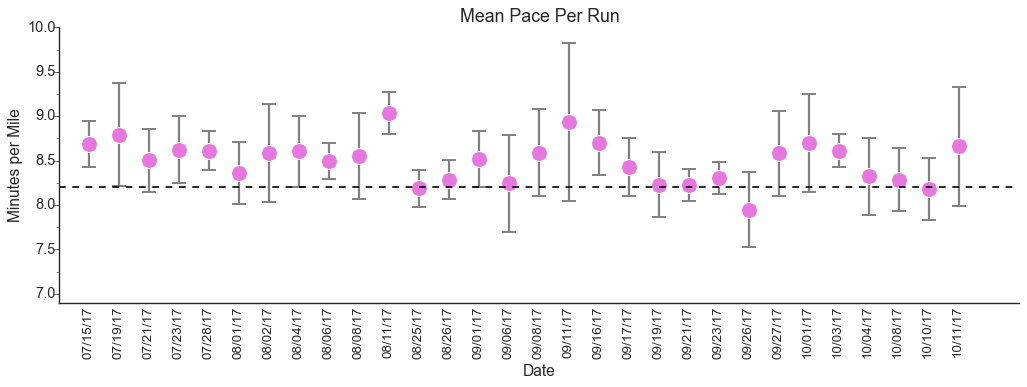

In [480]:
import numpy as np
from matplotlib.ticker import MultipleLocator 

ml = MultipleLocator(0.25)
plt.rcParams['figure.figsize'] = (13, 5)
sns.set_style('white')
(xyplot, caps, _) = plt.errorbar(x=mean_paces.index.tolist(), y=mean_paces[('min_per_mile', 'mean')],
           markersize=30, ecolor='gray', elinewidth=2, 
                            fmt='.', capsize=6, yerr=mean_paces[('min_per_mile', 'std')])
xyplot.set_markeredgecolor('white')
xyplot.set_markeredgewidth(1)
xyplot.set_markerfacecolor('#E577DE')
for cap in caps:
     cap.set_markeredgewidth(1.75)

# maroon '#800000'
plt.axhline(8.2, color='black', linestyle='--', lw=1.5)
plt.xticks(np.arange(0, 31), mean_paces[('date', '')], rotation='vertical')
plt.ylim(6.9, 10)
plt.xlim(-1, 31)
_ = plt.yticks(np.arange(7, 10.5, 0.5), size = 13)
plt.gca().axes.yaxis.set_minor_locator(ml)
plt.gca().axes.tick_params(axis='y', size=5, right='off', which='major')
plt.gca().axes.tick_params(axis='y', size=3, right='off', which='minor')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Mean Pace Per Run", size=16)
plt.xlabel("Date", size=14)
plt.xticks(size=12)
plt.ylabel("Minutes per Mile", size=14)
plt.tight_layout()
#plt.savefig("20171015_fig1.png")

In [388]:
#lap_df['average_cadence'] = np.where(lap_df['average_cadence'].isnull(),lap_df['average_cadence'].mean(), lap_df['average_cadence'])

In [450]:
lap_df['average_cadence'].isnull().sum()
lap_df.shape

(205, 15)

In [436]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

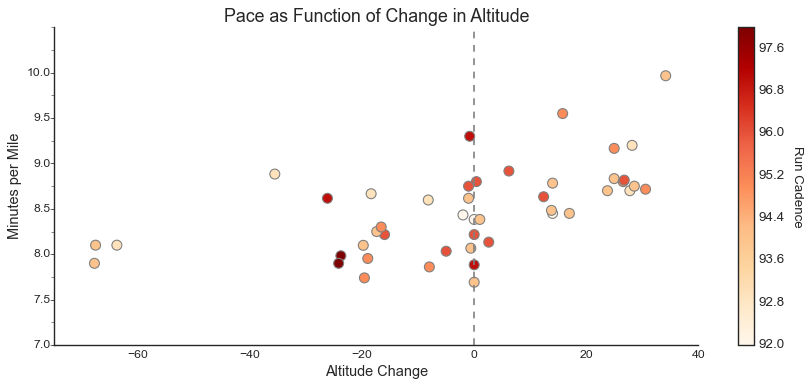

In [448]:
ml = MultipleLocator(0.25)

sns.set_style('white')
plt.rcParams['figure.figsize'] = (11, 5)
plt.scatter(x=lap_df['alt_change'], y=lap_df['min_per_mile'], c=lap_df['average_cadence'],
           s=80, edgecolor='gray')
plt.set_cmap('OrRd')
plt.xticks(rotation='horizontal')
cbar = plt.colorbar()
cbar.set_label("Run Cadence", rotation=270)
cbar.ax.get_yaxis().labelpad = 17
plt.axvline(0, color='gray', lw=1.5, linestyle='--')
plt.ylim(7, 10.5)
plt.title("Pace as Function of Change in Altitude", size=16)
_ = plt.yticks(np.arange(7, 10.5, 0.5), size = 11)
plt.gca().axes.yaxis.set_minor_locator(ml)
plt.gca().axes.tick_params(axis='y', size=5, right='off', which='major')
plt.gca().axes.tick_params(axis='y', size=3, right='off', which='minor')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("Altitude Change", size=13)
plt.xticks(size=11)
plt.xlim(-75,40)
plt.ylabel("Minutes per Mile", size=13)
plt.gca().axes.tick_params(axis='y', size=4, right='off')
plt.tight_layout()
plt.savefig("pace_vs_altitude.png")

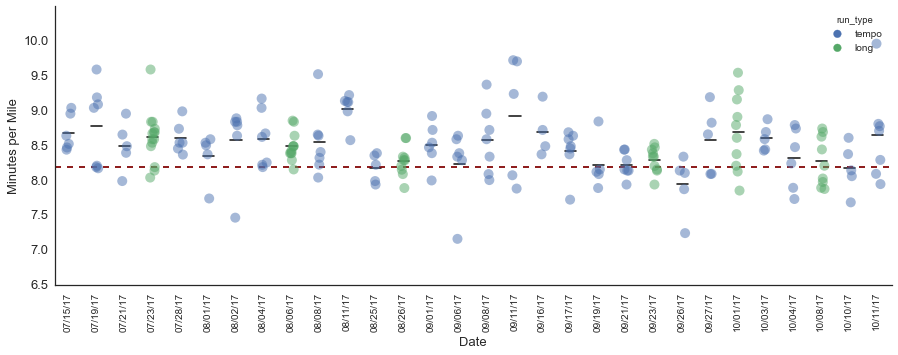

In [399]:
# experimentation 
plt.rcParams['figure.figsize'] = (15, 5)
sns.set_style('white')
sns.stripplot(data=lap_df, x='date', y='min_per_mile', jitter=True, alpha=0.5, s=10, hue='run_type')
sns.boxplot(data=mean_paces, x='date', y=mean_paces[('min_per_mile', 'mean')], width=0.4)
plt.axhline(8.2, color='#800000', linestyle='--')

plt.xticks(rotation='horizontal')
#plt.ylim(6, 10)
_ = plt.yticks(np.arange(6.5, 10.5, 0.5), size = 13)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(rotation='vertical')
plt.xlabel("Date", size=13)
plt.ylabel("Minutes per Mile", size=13)